In [156]:
!pip install --upgrade datasets

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import ToTensor
from datasets import load_dataset
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
from tqdm import tqdm
from collections import Counter
import random
from nltk.translate.bleu_score import corpus_bleu,SmoothingFunction
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Dataset Loading

In [158]:
dataset = load_dataset("tatoeba", lang1="ar", lang2="en")

In [159]:
dataset.keys()

dict_keys(['train'])

In [160]:
dataset.shape

{'train': (27905, 2)}

## Spliting dataset

In [161]:
train_valtest=dataset['train'].train_test_split(test_size=0.2,seed=42)
val_test=train_valtest['test'].train_test_split(test_size=0.5,seed=42)
train_data=train_valtest['train']
val_data=val_test['train']
test_data=val_test['test']

In [162]:
print(f'train_data: {train_data.shape}')
print(f'val_data: {val_data.shape}')
print(f'test_data: {test_data.shape}')

train_data: (22324, 2)
val_data: (2790, 2)
test_data: (2791, 2)


In [163]:
print(train_data['translation'][0]['ar'])

هل ترى ما أعني؟


## Text Preprocessing & Tokenization

In [164]:
def preprocess_arabic_text(text):
  # Remove diacritics
  arabic_diacritics = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
  text = re.sub(arabic_diacritics, '', text)
  # Remove Tatweel (Kashida)
  text = re.sub(r'ـ+', '', text)
    # Normalize letters
  replacements = {
        'أ': 'ا',
        'إ': 'ا',
        'آ': 'ا',
        'ى': 'ي',
        'ؤ': 'ء',
        'ئ': 'ء',
        'ة': 'ه',
        'گ': 'ك',
    }
  for src, target in replacements.items():
      text = text.replace(src, target)

  text=re.sub(r'[^\w\s]','',text)
  text=re.sub(r'\s+',' ',text).strip()
  tokens=word_tokenize(text)
  return tokens


def preprocess_english_text(text):
  text=text.lower()
  text=re.sub(r'\s+','',text).strip()
  tokens=word_tokenize(text)
  return tokens


In [165]:
train_input=[]
train_target=[]
for sample in tqdm(train_data['translation']):
  train_input.append(preprocess_arabic_text(sample['ar']))
  train_target.append(preprocess_english_text(sample['en']))


val_input=[]
val_target=[]
for sample in tqdm(val_data['translation']):
  val_input.append(preprocess_arabic_text(sample['ar']))
  val_target.append(preprocess_english_text(sample['en']))

test_input=[]
test_target=[]
for sample in tqdm(test_data['translation']):
  test_input.append(preprocess_arabic_text(sample['ar']))
  test_target.append(preprocess_english_text(sample['en']))


100%|██████████| 2791/2791 [00:00<00:00, 8392.23it/s]


In [166]:
print(train_input[0])
print(train_target[0])

['هل', 'تري', 'ما', 'اعني']
['do', 'you', 'see', 'what', 'i', 'mean', '?']


## Vocabulary Building

In [167]:
def build_arabic_vocab(input,max_words=10000):
  word_count=Counter()
  for sentence in input:
    word_count.update(sentence)
  most_common = word_count.most_common(max_words-2)
  vocab={word:idx+2 for idx,(word,_) in enumerate(most_common)}
  vocab['<PAD>'] = 0
  vocab['<UNK>'] = 1
  return vocab

In [168]:
def build_english_vocab(input,max_words=10000):
  word_count=Counter()
  for sentence in input:
    word_count.update(sentence)

  most_common = word_count.most_common(max_words-4)
  vocab={word:idx+4 for idx,(word,_) in enumerate(most_common)}
  vocab['<PAD>'] = 0
  vocab['<UNK>'] = 1
  vocab['<BOS>'] = 2
  vocab['<EOS>'] = 3

  return vocab


In [169]:
arabic_vocab=build_arabic_vocab(train_input)
english_vocab=build_english_vocab(train_target)
print(len(arabic_vocab))
print(len(english_vocab))

10000
8299


## Data Encoding

In [170]:
def plot_distribution(data):
  lengths = [len(sentence) for sentence in data]
  max_length = max(lengths)
  mean_length = np.mean(lengths)
  median_length = np.median(lengths)
  p95_length = np.percentile(lengths, 95)

  print(f"Maximum sentence length: {max_length}")
  print(f"Mean sentence length: {mean_length:.2f}")
  print(f"Median sentence length: {median_length}")
  print(f"95th percentile length: {p95_length}")

  plt.figure(figsize=(10, 6))
  plt.hist(lengths, bins=50)
  plt.axvline(x=max_length, color='r', linestyle='--', label=f'Max: {max_length}')
  plt.axvline(x=p95_length, color='g', linestyle='--', label=f'95th: {p95_length:.0f}')
  plt.axvline(x=median_length, color='b', linestyle='--', label=f'Median: {median_length}')
  plt.title("Distribution of sentence Lengths")
  plt.xlabel("Length (number of tokens)")
  plt.ylabel("Count")
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.show()

  truncated_count= sum(1 for length in lengths if length > p95_length )
  truncated_percentage = (truncated_count / len(lengths)) * 100
  print(f"Number of sentences truncated: {truncated_count}")
  print(f"Percentage of sentences truncated: {truncated_percentage:.2f}%")
  return p95_length


Maximum sentence length: 142
Mean sentence length: 5.09
Median sentence length: 4.0
95th percentile length: 10.0


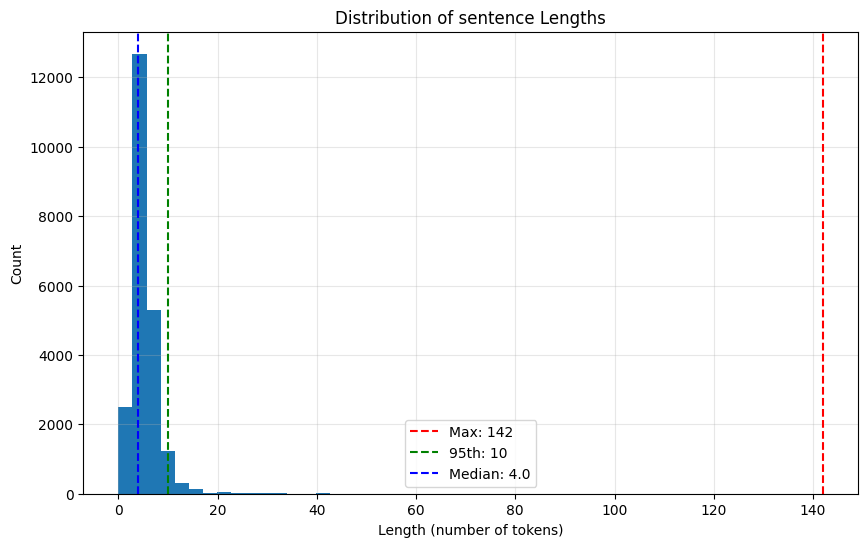

Number of sentences truncated: 844
Percentage of sentences truncated: 3.78%


In [171]:
arabic_length=plot_distribution(train_input)

Maximum sentence length: 232
Mean sentence length: 7.75
Median sentence length: 7.0
95th percentile length: 14.0


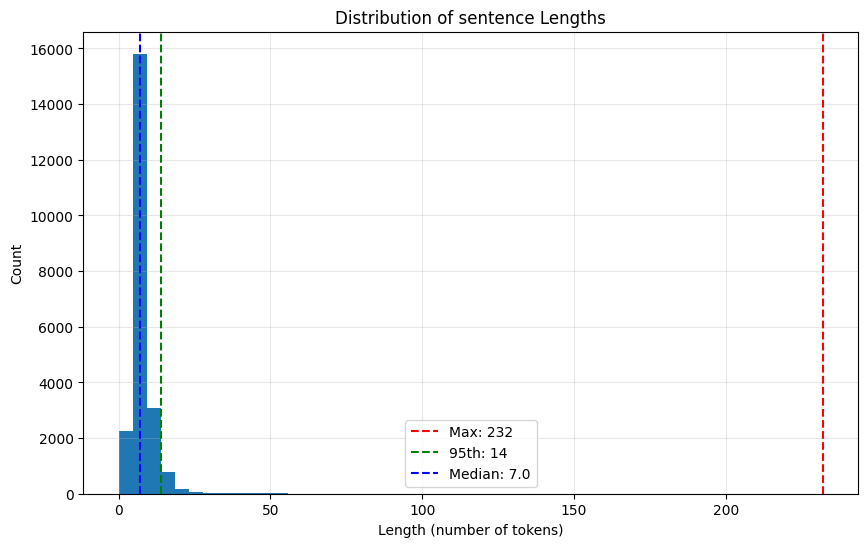

Number of sentences truncated: 906
Percentage of sentences truncated: 4.06%


In [172]:
english_length=plot_distribution(train_target)

In [173]:
def encode_arabic_sentence(sentence,vocab,max_length):
  max_length=int(max_length)
  encoded_sentence=[]
  for word in sentence:
    if word in vocab:
      encoded_sentence.append(vocab[word])
    else:
      encoded_sentence.append(vocab['<UNK>'])
  encoded_sentence=encoded_sentence[:max_length]
  if len(encoded_sentence)<max_length:
    encoded_sentence.extend([vocab['<PAD>']]*int(max_length-len(encoded_sentence)))
  return encoded_sentence

In [174]:
def encode_english_sentence(sentence,vocab,max_length):
  max_length=int(max_length)+2
  encoded_sentence=[vocab['<BOS>']]
  for word in sentence:
    if word in vocab:
      encoded_sentence.append(vocab[word])
    else:
      encoded_sentence.append(vocab['<UNK>'])
  encoded_sentence.append(vocab['<EOS>'])
  encoded_sentence=encoded_sentence[:max_length]
  if len(encoded_sentence)<max_length:
    encoded_sentence.extend([vocab['<PAD>']]*int(max_length-len(encoded_sentence)))
  return encoded_sentence

In [175]:
train_input_encoded=[encode_arabic_sentence(sentence,arabic_vocab,arabic_length) for sentence in train_input]
train_target_encoded=[encode_english_sentence(sentence,english_vocab,english_length) for sentence in train_target]

val_input_encoded=[encode_arabic_sentence(sentence,arabic_vocab,arabic_length) for sentence in val_input]
val_target_encoded=[encode_english_sentence(sentence,english_vocab,english_length) for sentence in val_target]

test_input_encoded=[encode_arabic_sentence(sentence,arabic_vocab,arabic_length) for sentence in test_input]
test_target_encoded=[encode_english_sentence(sentence,english_vocab,english_length) for sentence in test_target]

In [176]:
# convert to tensors
train_input_tensor=torch.tensor(train_input_encoded,dtype=torch.long)
train_target_tensor=torch.tensor(train_target_encoded,dtype=torch.long)

val_input_tensor=torch.tensor(val_input_encoded,dtype=torch.long)
val_target_tensor=torch.tensor(val_target_encoded,dtype=torch.long)

test_input_tensor=torch.tensor(test_input_encoded,dtype=torch.long)
test_target_tensor=torch.tensor(test_target_encoded,dtype=torch.long)

In [177]:
print(train_input_tensor.shape)
print(train_target_tensor.shape)
print(train_input_tensor[0])
print(train_target_tensor[0])

torch.Size([22324, 10])
torch.Size([22324, 16])
tensor([  13,  806,   14, 8455,    0,    0,    0,    0,    0,    0])
tensor([  2,  17,   8, 105,  34,   6, 484,  12,   3,   0,   0,   0,   0,   0,
          0,   0])


## DataLoader Preparation

In [178]:
class translationDataset(Dataset):
  def __init__(self,input,target):
    self.input=input
    self.target=target
  def __len__(self):
    return len(self.input)
  def __getitem__(self, index):
      return self.input[index], self.target[index]

In [179]:
train_dataset=translationDataset(train_input_tensor,train_target_tensor)
val_dataset=translationDataset(val_input_tensor,val_target_tensor)
test_dataset=translationDataset(test_input_tensor,test_target_tensor)

train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=16,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=16,shuffle=False)


In [180]:
batch_input,batch_target=next(iter(train_loader))
print(batch_input.shape)
print(batch_target.shape)
print(batch_input[0:3])
print(batch_target[0:3])

torch.Size([16, 10])
torch.Size([16, 16])
tensor([[   1,  684,  317,  101,    0,    0,    0,    0,    0,    0],
        [1080,    2,  189,    0,    0,    0,    0,    0,    0,    0],
        [  15, 8533,    9,   60,    0,    0,    0,    0,    0,    0]])
tensor([[   2,   20,   54, 2085,  394,   78,  458,  168,    4,    3,    0,    0,
            0,    0,    0,    0],
        [   2,   10, 1491,   21,    4,    3,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [   2,    6,   41,  729,    8,  114,  534,    4,    3,    0,    0,    0,
            0,    0,    0,    0]])


In [181]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

1396
175
175


## network architecture

In [182]:
class Encoder(nn.Module):
  def __init__(self,vocab_size,embedding_dim,hidden_dim,n_layers,dropout):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size,embedding_dim)
    self.lstm=nn.LSTM(embedding_dim,hidden_dim,n_layers,dropout=dropout,batch_first=True) 
  def forward(self,x):
    x=self.embedding(x)
    output,(hidden,cell)=self.lstm(x)
      
    return hidden,cell

In [183]:
def convert_bi_to_uni(hidden):
    # hidden: (num_layers*2, batch, hidden_dim)
    num_layers = hidden.size(0) // 2
    new_hidden = []
    for i in range(num_layers):
        forward = hidden[2*i, :, :]
        backward = hidden[2*i+1, :, :]
        new_hidden.append(torch.cat((forward, backward), dim=1))  # concat on hidden_dim
    return torch.stack(new_hidden, dim=0)

In [184]:
class decoder(nn.Module):
  def __init__(self,output_dim,embedding_dim,hidden_dim,n_layers,dropout):
    super().__init__()
    self.output_dim=output_dim
    self.embedding=nn.Embedding(output_dim,embedding_dim)
    self.lstm=nn.LSTM(embedding_dim,hidden_dim,n_layers,dropout=dropout,batch_first=True)
    self.dropout = nn.Dropout(dropout)    
    self.fc=nn.Linear(hidden_dim,output_dim)
    
  def forward(self,x,hidden,cell):
    x=x.unsqueeze(1)
    x=self.embedding(x)
    output,(hidden,cell)=self.lstm(x,(hidden,cell))
    output=self.dropout(output)  
    prediction=self.fc(output.squeeze(1))
    return prediction,hidden,cell


In [185]:
class TranslationModel(nn.Module):
  def __init__(self,encoder,decoder,device):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.device=device
  def forward(self,input,target,teacher_forcing_ratio=0.5):
    batch_size=input.shape[0]
    target_len=target.shape[1]
    target_vocab_size=self.decoder.output_dim
    outputs=torch.zeros(batch_size,target_len,target_vocab_size).to(self.device)
    hidden,cell=self.encoder(input)
    x=target[:,0]
    for t in range(1,target_len):
      output,hidden,cell=self.decoder(x,hidden,cell)
      outputs[:,t]=output
      teach_force=random.random()<teacher_forcing_ratio
      top1=output.argmax(1)
      x=target[:,t] if teach_force else top1
    return outputs


In [186]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training & Evaluation

In [187]:
def train(model,data_loader,optimizer,criterion,device,clip=1.0,teach_force=0.5):
  model.train()
  epoch_loss=0
  for batch_input,batch_target in tqdm(data_loader):
    batch_input=batch_input.to(device)
    batch_target=batch_target.to(device)
    optimizer.zero_grad()
    output=model(batch_input,batch_target,teach_force)
    output_dim=output.shape[-1]
    output=output[:,1:].reshape(-1,output_dim)
    batch_target=batch_target[:,1:].reshape(-1)
    loss=criterion(output,batch_target)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
    optimizer.step()
    epoch_loss+=loss.item()
  return epoch_loss/len(data_loader)


In [188]:
def truncate_eos(tokens, eos_token):
    if eos_token in tokens:
        idx = tokens.index(eos_token)
        return tokens[:idx]
    return tokens

In [189]:
def evaluate(model,data_loader,criterion,device,input_vocab,target_vocab,reverse_vocab):
  model.eval()
  epoch_loss=0
  all_reference=[]
  all_candidate=[]
  with torch.no_grad():
    for batch_input,batch_target in tqdm(data_loader):
      batch_input=batch_input.to(device)
      batch_target=batch_target.to(device)
      dim1=batch_target.shape[0]
      dim2=batch_target.shape[1]-1
      output=model(batch_input,batch_target,0)
      output_dim=output.shape[-1]
      output=output[:,1:].reshape(-1,output_dim)
      batch_target=batch_target[:,1:].reshape(-1)
      loss=criterion(output,batch_target)
      epoch_loss+=loss.item()
      pred_tokens=output.argmax(-1)
      batch_target=batch_target.reshape(dim1,dim2)
      pred_tokens=pred_tokens.reshape(dim1,dim2)
      for i in range(batch_target.size(0)):
        reference = [reverse_vocab[token] for token in batch_target[i].tolist() if token != english_vocab['<PAD>']]
        candidate = [reverse_vocab[token] for token in pred_tokens[i].tolist() if token != english_vocab['<PAD>']]
        reference = truncate_eos([reverse_vocab[token] for token in batch_target[i].tolist()], '<EOS>')
        candidate = truncate_eos([reverse_vocab[token] for token in pred_tokens[i].tolist()], '<EOS>')
        all_reference.append([reference])
        all_candidate.append(candidate)

 
  bleu_score = corpus_bleu(all_reference, all_candidate)
  return epoch_loss/len(data_loader),bleu_score,all_reference,all_candidate

In [190]:
input_dim=len(arabic_vocab)
output_dim=len(english_vocab)
embedding_dim=256
hidden_dim=512
n_layers=2
dropout=0.5
encoder=Encoder(input_dim,embedding_dim,hidden_dim,n_layers,dropout)
decoder=decoder(output_dim,embedding_dim,hidden_dim,n_layers,dropout)
model=TranslationModel(encoder,decoder,device).to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)
criterion=nn.CrossEntropyLoss(ignore_index=english_vocab['<PAD>'])


In [191]:
reverse_vocab={idx:word for word,idx in english_vocab.items()}

In [192]:
num_epoch=50
loss_train=[]
loss_val=[]
for epoch in range(num_epoch):
  train_loss=train(model,train_loader,optimizer,criterion,device)
  val_loss,val_score,reference,candidate=evaluate(model,val_loader,criterion,device,arabic_vocab,english_vocab,reverse_vocab)
  loss_train.append(train_loss)
  loss_val.append(val_loss)
  if epoch % 5 == 0:
    print(f"\nSample prediction at epoch {epoch}:")
    print(f"Reference: {' '.join(reference[-1][0])}")
    print(f"Candidate: {' '.join(candidate[-1])}")
  print(f'Epoch: {epoch+1}/{num_epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, BLEU Score: {val_score:.4f}')



100%|██████████| 175/175 [00:01<00:00, 92.10it/s]



Sample prediction at epoch 0:
Reference: i 'm trying to understand why you did n't do it .
Candidate: i do n't know you you to . .
Epoch: 1/50: Train Loss: 5.0500, Val Loss: 4.8834, BLEU Score: 0.0140


100%|██████████| 175/175 [00:01<00:00, 90.67it/s]


Epoch: 2/50: Train Loss: 4.5554, Val Loss: 4.6231, BLEU Score: 0.0206


100%|██████████| 175/175 [00:01<00:00, 91.99it/s]


Epoch: 3/50: Train Loss: 4.3056, Val Loss: 4.4811, BLEU Score: 0.0264


100%|██████████| 175/175 [00:02<00:00, 81.39it/s]


Epoch: 4/50: Train Loss: 4.1430, Val Loss: 4.3739, BLEU Score: 0.0351


100%|██████████| 175/175 [00:01<00:00, 90.36it/s]


Epoch: 5/50: Train Loss: 4.0040, Val Loss: 4.2380, BLEU Score: 0.0400


100%|██████████| 175/175 [00:02<00:00, 80.90it/s]



Sample prediction at epoch 5:
Reference: i 'm trying to understand why you did n't do it .
Candidate: i think i know you i do n't know you .
Epoch: 6/50: Train Loss: 3.8910, Val Loss: 4.1841, BLEU Score: 0.0496


100%|██████████| 175/175 [00:01<00:00, 93.77it/s]


Epoch: 7/50: Train Loss: 3.7964, Val Loss: 4.0899, BLEU Score: 0.0548


100%|██████████| 175/175 [00:01<00:00, 91.46it/s]


Epoch: 8/50: Train Loss: 3.7085, Val Loss: 4.0455, BLEU Score: 0.0606


100%|██████████| 175/175 [00:01<00:00, 90.89it/s]


Epoch: 9/50: Train Loss: 3.6409, Val Loss: 3.9756, BLEU Score: 0.0635


100%|██████████| 175/175 [00:01<00:00, 91.22it/s]


Epoch: 10/50: Train Loss: 3.5779, Val Loss: 3.9387, BLEU Score: 0.0660


100%|██████████| 175/175 [00:01<00:00, 90.86it/s]



Sample prediction at epoch 10:
Reference: i 'm trying to understand why you did n't do it .
Candidate: i 'm not to you you n't n't know what i do n't .
Epoch: 11/50: Train Loss: 3.5226, Val Loss: 3.9029, BLEU Score: 0.0718


100%|██████████| 175/175 [00:01<00:00, 91.92it/s]


Epoch: 12/50: Train Loss: 3.4788, Val Loss: 3.8681, BLEU Score: 0.0830


100%|██████████| 175/175 [00:01<00:00, 90.73it/s]


Epoch: 13/50: Train Loss: 3.4416, Val Loss: 3.8239, BLEU Score: 0.0825


100%|██████████| 175/175 [00:01<00:00, 91.18it/s]


Epoch: 14/50: Train Loss: 3.4076, Val Loss: 3.7911, BLEU Score: 0.0867


100%|██████████| 175/175 [00:01<00:00, 92.39it/s]


Epoch: 15/50: Train Loss: 3.3798, Val Loss: 3.8011, BLEU Score: 0.0811


100%|██████████| 175/175 [00:01<00:00, 91.45it/s]



Sample prediction at epoch 15:
Reference: i 'm trying to understand why you did n't do it .
Candidate: i 'm not to i i not not what .
Epoch: 16/50: Train Loss: 3.3524, Val Loss: 3.8177, BLEU Score: 0.0910


100%|██████████| 175/175 [00:01<00:00, 92.86it/s]


Epoch: 17/50: Train Loss: 3.3292, Val Loss: 3.8038, BLEU Score: 0.0881


100%|██████████| 175/175 [00:01<00:00, 91.84it/s]


Epoch: 18/50: Train Loss: 3.3176, Val Loss: 3.7792, BLEU Score: 0.0926


100%|██████████| 175/175 [00:01<00:00, 91.42it/s]


Epoch: 19/50: Train Loss: 3.3004, Val Loss: 3.7584, BLEU Score: 0.0928


100%|██████████| 175/175 [00:01<00:00, 92.11it/s]


Epoch: 20/50: Train Loss: 3.2795, Val Loss: 3.7899, BLEU Score: 0.0978


100%|██████████| 175/175 [00:01<00:00, 90.20it/s]



Sample prediction at epoch 20:
Reference: i 'm trying to understand why you did n't do it .
Candidate: i 'm not to you you what what you do n't .
Epoch: 21/50: Train Loss: 3.2661, Val Loss: 3.7605, BLEU Score: 0.0947


100%|██████████| 175/175 [00:01<00:00, 93.09it/s]


Epoch: 22/50: Train Loss: 3.2608, Val Loss: 3.7623, BLEU Score: 0.1011


100%|██████████| 175/175 [00:02<00:00, 81.61it/s]


Epoch: 23/50: Train Loss: 3.2465, Val Loss: 3.7205, BLEU Score: 0.0987


100%|██████████| 175/175 [00:01<00:00, 92.68it/s]


Epoch: 24/50: Train Loss: 3.2341, Val Loss: 3.7415, BLEU Score: 0.0983


100%|██████████| 175/175 [00:02<00:00, 79.89it/s]


Epoch: 25/50: Train Loss: 3.2287, Val Loss: 3.7458, BLEU Score: 0.1025


100%|██████████| 175/175 [00:01<00:00, 92.20it/s]



Sample prediction at epoch 25:
Reference: i 'm trying to understand why you did n't do it .
Candidate: i do n't know you ca n't know .
Epoch: 26/50: Train Loss: 3.2157, Val Loss: 3.7340, BLEU Score: 0.0991


100%|██████████| 175/175 [00:01<00:00, 92.06it/s]


Epoch: 27/50: Train Loss: 3.2128, Val Loss: 3.7571, BLEU Score: 0.1031


100%|██████████| 175/175 [00:01<00:00, 92.41it/s]


Epoch: 28/50: Train Loss: 3.2106, Val Loss: 3.7324, BLEU Score: 0.0970


100%|██████████| 175/175 [00:01<00:00, 90.17it/s]


Epoch: 29/50: Train Loss: 3.2103, Val Loss: 3.7225, BLEU Score: 0.1045


100%|██████████| 175/175 [00:01<00:00, 88.70it/s]


Epoch: 30/50: Train Loss: 3.2043, Val Loss: 3.7204, BLEU Score: 0.1058


100%|██████████| 175/175 [00:01<00:00, 92.26it/s]



Sample prediction at epoch 30:
Reference: i 'm trying to understand why you did n't do it .
Candidate: i 'm not to know what i know what .
Epoch: 31/50: Train Loss: 3.2039, Val Loss: 3.7360, BLEU Score: 0.1046


100%|██████████| 175/175 [00:01<00:00, 90.39it/s]


Epoch: 32/50: Train Loss: 3.1947, Val Loss: 3.7308, BLEU Score: 0.1052


100%|██████████| 175/175 [00:01<00:00, 91.71it/s]


Epoch: 33/50: Train Loss: 3.1982, Val Loss: 3.7225, BLEU Score: 0.1099


100%|██████████| 175/175 [00:01<00:00, 91.56it/s]


Epoch: 34/50: Train Loss: 3.1918, Val Loss: 3.7396, BLEU Score: 0.1062


100%|██████████| 175/175 [00:01<00:00, 93.05it/s]


Epoch: 35/50: Train Loss: 3.1906, Val Loss: 3.7180, BLEU Score: 0.1025


100%|██████████| 175/175 [00:01<00:00, 91.40it/s]



Sample prediction at epoch 35:
Reference: i 'm trying to understand why you did n't do it .
Candidate: i 'm not to i i do n't know .
Epoch: 36/50: Train Loss: 3.1818, Val Loss: 3.7437, BLEU Score: 0.1044


100%|██████████| 175/175 [00:01<00:00, 92.33it/s]


Epoch: 37/50: Train Loss: 3.1839, Val Loss: 3.7188, BLEU Score: 0.1041


100%|██████████| 175/175 [00:01<00:00, 92.40it/s]


Epoch: 38/50: Train Loss: 3.1791, Val Loss: 3.7181, BLEU Score: 0.1002


100%|██████████| 175/175 [00:01<00:00, 94.13it/s]


Epoch: 39/50: Train Loss: 3.1874, Val Loss: 3.7574, BLEU Score: 0.1005


100%|██████████| 175/175 [00:01<00:00, 89.68it/s]


Epoch: 40/50: Train Loss: 3.1715, Val Loss: 3.7215, BLEU Score: 0.1045


100%|██████████| 175/175 [00:01<00:00, 92.62it/s]



Sample prediction at epoch 40:
Reference: i 'm trying to understand why you did n't do it .
Candidate: i 'm not tell what i know n't .
Epoch: 41/50: Train Loss: 3.1830, Val Loss: 3.7622, BLEU Score: 0.1021


100%|██████████| 175/175 [00:02<00:00, 82.24it/s]


Epoch: 42/50: Train Loss: 3.1799, Val Loss: 3.7801, BLEU Score: 0.1046


100%|██████████| 175/175 [00:01<00:00, 91.99it/s]


Epoch: 43/50: Train Loss: 3.1792, Val Loss: 3.7119, BLEU Score: 0.1046


100%|██████████| 175/175 [00:02<00:00, 83.25it/s]


Epoch: 44/50: Train Loss: 3.1754, Val Loss: 3.7575, BLEU Score: 0.1003


100%|██████████| 175/175 [00:01<00:00, 91.86it/s]


Epoch: 45/50: Train Loss: 3.1763, Val Loss: 3.7313, BLEU Score: 0.1046


100%|██████████| 175/175 [00:01<00:00, 93.19it/s]



Sample prediction at epoch 45:
Reference: i 'm trying to understand why you did n't do it .
Candidate: i ca n't understand that , i do n't .
Epoch: 46/50: Train Loss: 3.1803, Val Loss: 3.7351, BLEU Score: 0.1071


100%|██████████| 175/175 [00:01<00:00, 91.70it/s]


Epoch: 47/50: Train Loss: 3.1819, Val Loss: 3.7427, BLEU Score: 0.0981


100%|██████████| 175/175 [00:01<00:00, 90.24it/s]


Epoch: 48/50: Train Loss: 3.1812, Val Loss: 3.7363, BLEU Score: 0.1101


100%|██████████| 175/175 [00:01<00:00, 90.94it/s]


Epoch: 49/50: Train Loss: 3.1856, Val Loss: 3.7672, BLEU Score: 0.1058


100%|██████████| 175/175 [00:01<00:00, 92.80it/s]


Epoch: 50/50: Train Loss: 3.1785, Val Loss: 3.7568, BLEU Score: 0.1048


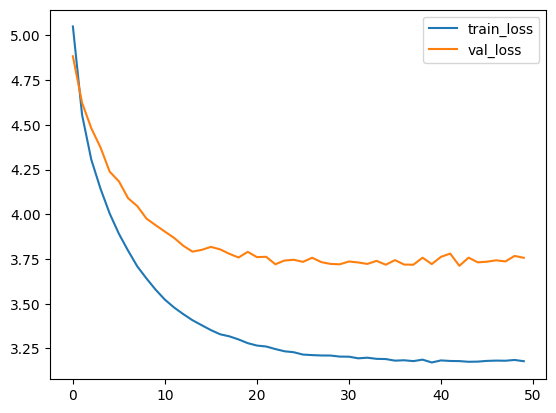

In [193]:
plt.plot(loss_train,label='train_loss')
plt.plot(loss_val,label='val_loss')
plt.legend()
plt.show()

In [194]:
test_loss,test_score,reference,candidate=evaluate(model,test_loader,criterion,device,arabic_vocab,english_vocab,reverse_vocab)
print(f'Test Loss: {test_loss:.4f}, BLEU Score: {test_score:.4f}')

100%|██████████| 175/175 [00:01<00:00, 92.11it/s]


Test Loss: 3.8113, BLEU Score: 0.0997


In [200]:
for i in range(2,10):
   print(f"Reference: {' '.join(reference[i][0])}")
   print(f"Candidate: {' '.join(candidate[i])}")

Reference: sami had a really weird voice .
Candidate: sami had a really really .
Reference: wish me luck !
Candidate: he gave to a a .
Reference: i am in the music club .
Candidate: i 'm in the . .
Reference: sami 's house was a hell hole .
Candidate: sami 's house was a .
Reference: it was careless of her to forget it .
Candidate: he was him to see him .
Reference: they will get married next month .
Candidate: we 'll be next next .
Reference: mariko speaks english excellently .
Candidate: english speaks english .
Reference: sami and layla were really good friends with a couple from the church .
Candidate: sami and layla were to to to and and and and and .
